In [1]:
import time
import itertools as it

import matplotlib.pyplot as plt
import numpy as np
import pylab as pl
from IPython import display

from Node.functions import *
from Node.Node import Control_node
from Plant.Plant import Plant

### Super Complex Behavior

In [2]:
def matrix_deriv(mat, features, steps):
  trans = mat.transpose()
  deriv = np.empty([features, steps-1])
  for feat in range(len(trans)):
    deriv[feat] = np.diff(trans[feat], 1)
    # for val in range(len(deriv[feat])):
    #   if deriv[feat][val] < 0.000001 and deriv[feat][val] > -0.000001:
    #     deriv[feat][val] = 0.01
  return deriv.transpose()

In [3]:
behav_size = 200
sigmoid_k = 200000000000
sigmoid_b = 20
# behavioral matrix (maps previous behavior to future behavior commands - how should I behave?)
# behavioral matrix (maps previous behavior to future behavior commands - how should I behave?)
B1 = np.random.rand(behav_size, behav_size)
B2 = np.random.rand(behav_size, behav_size)
# B1 = np.array([[1]])
# B2 = np.array([[1]])

# state/system matrix (maps previous state to future state - how will others behave (give past behaviors)?)
A1 = np.random.rand(1, behav_size)
A2 = np.random.rand(1, behav_size)

# reference matrix (how do I expect/want others to behave? target values)
R1 = np.random.rand(1, behav_size)
R2 = np.random.rand(1, behav_size)

# Initial behavior
behav_1 = np.random.rand(1, behav_size)
behav_2 = np.random.rand(1, behav_size)

# transition matrix (maps control signal and previous state to current state - what behaviors do I enact given my intentions?)
T1 = np.array([.05])
T2 = np.array([.05])

color2 = [0.1,0.6,0.2, 0.7]
color2c = [0.2,0.9,0.3, 0.4]

# get the state observation (behaviors of others)
def sense(inputs):
    perception = inputs
    return perception

# contrast reference with observations (and potentially incorporate predictions from internal model)
def compare(sensory_signal, reference, prediction):
    error = reference - sensory_signal
    return error

# generate a control signal
def control(error, behavioral_model, previous_output):
    control_signal = chaotic_controller(behavioral_model, 0.00001, error)
    # print(error, control_signal)
    # print(error/control_signal)
    return control_signal

# dictates how control commands determine state transitions - i.e. behaviors
def transition(control_signal, transition_matrix, state):
    new_state = (transition_matrix * control_signal) + state
    new_state[new_state > 1] = 1
    new_state[new_state < 0] = 0.0001
    return new_state


# adjusts behavioral model to get closer to behavior given 
def control_update(error, behavioral_model, previous_output):
    # LMS algorithm
    learning_rate = 0.0
    #behavioral_model = behavioral_model + learning_rate * error * previous_output
    return behavioral_model

# adjusts reference given error
def reference_update_true(reference, error):
    k = 0.1
    reference = reference - (error * k)
    reference[reference > 1] = 1
    reference[reference < 0] = 0.0001
    return reference

# does not adjust reference
def reference_update_false(reference, error):
    k = 0
    reference = reference + (error * k)
    return reference

def reference_update_sigmoid(reference, error):
    # reference = (matrix_sigmoid(error)-1)*(R1) + matrix_sigmoid(error)*(reference + error)
    sqr_error = np.square(error)
    reference = shifted_sigmoid(sqr_error, sigmoid_k, sigmoid_b)*(reference - error) + (1-shifted_sigmoid(sqr_error, sigmoid_k, sigmoid_b))*(R1)
    # k = 0.1
    # k =  zero_sigmoid(error)
    # reference = reference - (error * k)
    return reference

# generate predictions on next state
def imc(system_estimate, previous_state, behavioral_model, previous_output):
    # actual estimate
    state = (system_estimate * previous_state) + (behavioral_model * previous_output)
    return state

# adjust system estimate to infer observations given my behavior
def imc_update(inputs, system_estimate, previous_behavior, behavioral_model, previous_state, learning_rate):
    # actual estimate
    #curr_system_est = (system_estimate @ previous_state) + (behavioral_model @ previous_behavior)
    #error = curr_system_est - inputs
    #learning_rate = 0.01
    #system_estimate = system_estimate + learning_rate * error * previous_behavior
    return system_estimate

plant1 = Plant(transition_matrix=T1, transition_function=transition, state=behav_1)
plant2 = Plant(transition_matrix=T2, transition_function=transition, state=behav_2)

conformist1 = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_true,
controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
system_estimate=A1, reference=R1, init_behavior=behav_1)

conformist2 = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_true,
controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
system_estimate=A1, reference=R1, init_behavior=behav_1)

stubborn = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_false,
controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B2, 
system_estimate=A2, reference=R2, init_behavior=behav_2)

sigmoid = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_sigmoid,
controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
system_estimate=A1, reference=R1, init_behavior=behav_1)

Seed was: 354


/Users/rpassas/Documents/SoS/sos_env/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/rpassas/Documents/SoS/sos_env/lib/python3.10/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


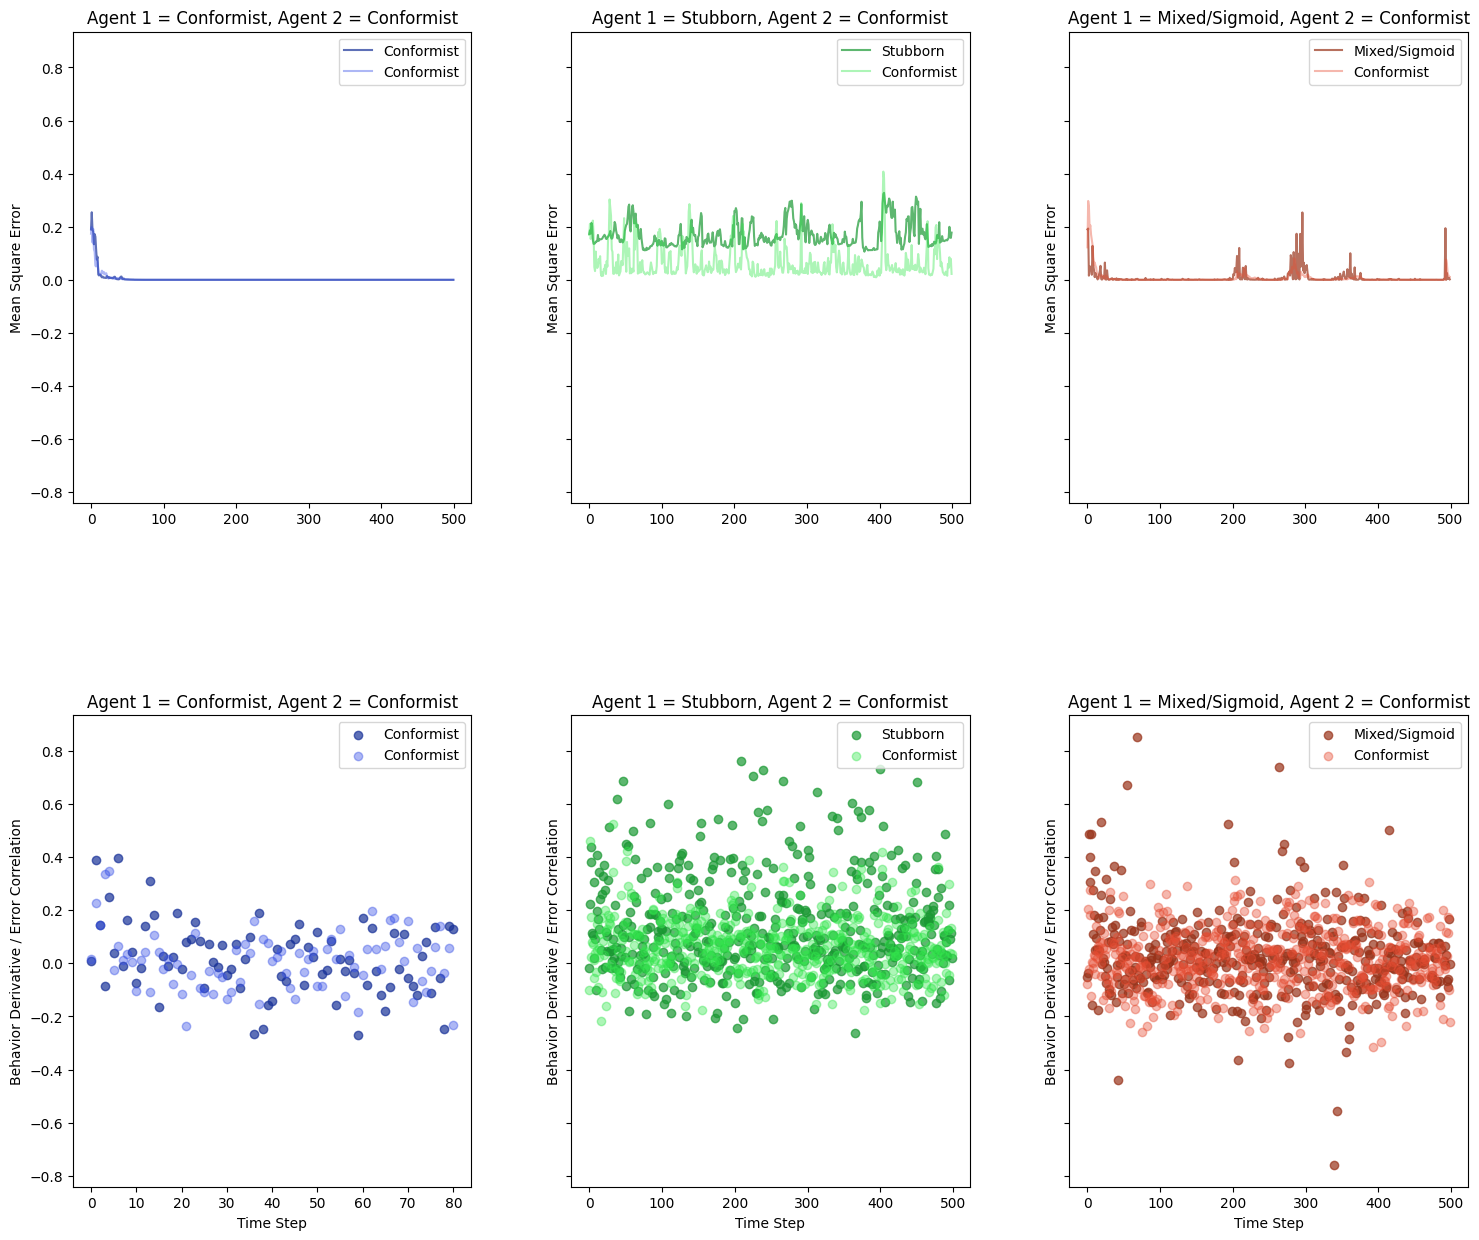

In [4]:
seed = random.randrange(1000)
# seed = 817
# rng = random.Random(seed)
print("Seed was:", seed)
np.random.seed(seed)
w = 6; h = 5
ncols = 3
nrows = 1
param_vals = [i for i in range(0, ncols*nrows)]
tups = list(it.product(range(nrows), range(ncols)))
agents_label = ["Conformist", "Stubborn", "Mixed/Sigmoid"]
agents1 = [conformist2, stubborn, sigmoid]
agents2 = [conformist1, conformist1, conformist1]
fig, ax = plt.subplots(nrows*2, ncols, figsize=(w*ncols, h*nrows*3), dpi=100,
                       sharey=True)#, sharex=True)
plt.subplots_adjust(wspace=0.25,hspace=0.45)
trials = 500
time = [i for i in range(trials)]

color1 = [0.1,0.2,0.6, 0.7]
color1c = [0.2,0.3,0.9, 0.4]
color2 = [0.1,0.6,0.2, 0.7]
color2c = [0.2,0.9,0.3, 0.4]
color3 = [0.6,0.2,0.1, 0.7]
color3c = [0.9,0.3,0.2, 0.4]
colors = [color1,color2,color3]
colors_c = [color1c,color2c,color3c]
color_black = [0.1,0.1,0.1,0.5]

for ix, param in enumerate(param_vals):
    # experiments
    conformist1 = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_true,
    controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
    system_estimate=A1, reference=R1, init_behavior=behav_1)

    conformist2 = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_true,
    controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
    system_estimate=A1, reference=R1, init_behavior=behav_1)

    stubborn = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_false,
    controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B2, 
    system_estimate=A2, reference=R2, init_behavior=behav_2)

    sigmoid = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_sigmoid,
    controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
    system_estimate=A1, reference=R1, init_behavior=behav_1)

    plant1 = Plant(transition_matrix=T1, transition_function=transition, state=np.random.rand(1, behav_size))
    plant2 = Plant(transition_matrix=T2, transition_function=transition, state=np.random.rand(1, behav_size))

    b1 = np.random.rand(1, behav_size)
    b2 = np.random.rand(1, behav_size)

    agent1 = agents1[param%3]
    agent2 = agents2[0]
    agent1_error = []
    agent2_error = []
    agent1_raw_error = []
    agent2_raw_error = []
    sigmoid_value = []
    agent1_behaviors = []
    agent2_behaviors = []
    agent1_control = []
    agent2_control = []
    agent1_reference = []
    agent2_reference = []
    agent1_pref_error = []
    agent2_pref_error = []
    for t in range(trials):
        color1 = [0.1,0.2,0.8, (t+1)/(trials+1)]
        color2 = [0.1,0.8,0.2, (t+1)/(trials+1)]
        #pl.scatter(agent1.get_reference()[0],-0.03, c=color1, edgecolors=[0.8,0.1,0.1, color1[1]])
        #pl.scatter(agent2.get_reference()[0],0, c=color2, edgecolors=[0.8,0.1,0.1, color2[3]], linewidth=1.5)
        b1_control = agent1.go(b2)   
        b2_control = agent2.go(b1)

        agent1_control.append(agent1.get_output())
        agent2_control.append(agent2.get_output())

        b1 = plant1.transition(b1_control)
        b2 = plant2.transition(b2_control)
        
        agent1_behaviors.append(b1)
        agent2_behaviors.append(b2)

        # agent1_error.append(np.absolute(agent1.get_error()))
        # agent2_error.append(np.absolute(agent2.get_error()))
        agent1_raw_error.append(agent1.get_error()[0])
        agent2_raw_error.append(agent2.get_error()[0])
        agent1_pref_error.append(np.sum(np.absolute(R2-b1))/len(agent1.get_error()[0]))
        agent2_pref_error.append(np.sum(np.absolute(R1-b2))/len(agent2.get_error()[0]))
        # if b1[0][0] == 0.0 or b1[0][0] == 1.0:
        #   agent1_raw_error.append(b1[0][0]+0.001)
        # else:
        #   agent1_raw_error.append(agent1.get_error()[0][0])
        # if b2[0][0] == 0.0 or b2[0][0] == 1.0:
        #    agent2_raw_error.append(b2[0][0]+0.001)
        # else:
        #   agent2_raw_error.append(agent2.get_error()[0][0])
        
        agent1_error.append(np.sum(np.square(agent1.get_error()[0]))/len(agent1.get_error()[0]))
        agent2_error.append(np.sum(np.square(agent2.get_error()[0]))/len(agent2.get_error()[0]))
        if agents_label[param] == "Mixed/Sigmoid": 
          sqr_error = np.square(agent2.get_error()[0])
          sigmoid_value.append(shifted_sigmoid(sqr_error, sigmoid_k, sigmoid_b))

        agent1_reference.append(agent1.get_reference()[0])
        agent2_reference.append(agent2.get_reference()[0])

    ai = tups[ix]
    color = colors[param]
    color_c = colors_c[param]
    # plots
    ax[ai].plot(time, agent1_error, color=color, label=agents_label[param])
    ax[ai].plot(time, agent2_error, color=color_c, label="Conformist")
    # if agents_label[param] == "Mixed/Sigmoid": 
    #   ax[ai].plot(time, sigmoid_value, color=color_black, label="Sigmoid Strategy")
    #   print(sigmoid_value)
    ax[ai].set_title('Agent 1 = {}, Agent 2 = Conformist'.format(agents_label[param%3]))
    ax[ai].legend()
    # ax[ai].set_xlim(0,t)
    # ax[ai].set_ylim(0,1)
    ax[ai].tick_params(axis='x')
    ax[ai].tick_params(axis='y')
    ax[ai].set_ylabel("Mean Square Error")
    # ax[ai].set_xlabel("Time Step")

    # derivative charts
    dx = 1
    # b1_flat = [i[0] for i in agent1_control]
    # b2_flat = [i[0] for i in agent2_control]
    b1_flat = [i[0]for i in agent1_behaviors]
    # print("ag 1 behaviors: ", agent1_behaviors)
    # print("ag 1 flat behaviors: ", b1_flat)
    b2_flat = [i[0]for i in agent2_behaviors]
    # d_behav1 = abs(np.gradient(b1_flat, dx))
    # d_behav2 = abs(np.gradient(b2_flat, dx))
    # d_behav1 = np.insert(np.diff(b1_flat, dx), 0, 0)
    d_behav1 = matrix_deriv(np.array(b1_flat), behav_size, trials)
    # print("ag 1 behav deriv: ", d_behav1)
    # d_behav2 = np.insert(np.diff(b2_flat, dx), 0, 0)
    d_behav2 = matrix_deriv(np.array(b2_flat), behav_size, trials)
    # print("agent1_raw_error: ", agent1_raw_error)
    # agent1_raw_error.insert(-1, 1)
    # print("agent1_raw_error inserted: ", agent1_raw_error)
    # agent2_raw_error.insert(-1, 1)
    agent1_raw_error_shifted = agent1_raw_error[:-1]
    agent2_raw_error_shifted = agent2_raw_error[:-1]

    # print(agents_label[param%3], "ratio: ", np.average(abs(d_behav1/agent2_raw_error_shifted)))
    # print(agents_label[0], "ratio: ", np.average(abs(d_behav2/agent1_raw_error_shifted)))
    # print(agents_label[param%3], "+ Conformist covariance:", np.cov(np.absolute(d_behav1), np.absolute(agent2_raw_error_shifted)))
    # print(agents_label[0], "&",agents_label[param%3], "covariance:", np.cov(np.absolute(d_behav2), np.absolute(agent1_raw_error_shifted)))
    # print(agents_label[param%3], "& Conformist Pearson R:", np.corrcoef(np.absolute(d_behav1), np.absolute(agent2_raw_error_shifted))[0][1])
    # print(agents_label[0], "&", agents_label[param%3], " Pearson R:", np.corrcoef(np.absolute(d_behav2), np.absolute(agent1_raw_error_shifted))[0][1])
    # print("---")

    # print(agents_label[param])
    # print("error: ", agent2_raw_error_shifted)
    # print("d_behav: ", d_behav1)
    coef1 = [np.corrcoef(d_behav1[i], agent2_raw_error_shifted[i])[0][1] for i in range(len(d_behav1))]
    # print(coef1)
    coef2 = [np.corrcoef(d_behav2[i], agent1_raw_error_shifted[i])[0][1] for i in range(len(d_behav2))]
    
    ax[(ai[0]+1,ai[1])].scatter([ i for i in range(trials-1)], coef1, color=color, label="{}".format(agents_label[param]))
    # ax[(ai[0]+1,ai[1])].scatter(np.absolute(d_behav1), np.absolute(agent2_raw_error_shifted), color=color, label="{}".format(agents_label[param]))
    ax[(ai[0]+1,ai[1])].scatter([ i for i in range(trials-1)], coef2, color=color_c, label="Conformist")
    # ax[(ai[0]+1,ai[1])].scatter(np.absolute(d_behav2), np.absolute(agent1_raw_error_shifted), color=color_c, label="Conformist")

    ax[(ai[0]+1,ai[1])].set_title('Agent 1 = {}, Agent 2 = Conformist'.format(agents_label[param%3]))
    ax[(ai[0]+1,ai[1])].legend()
    # ax[ai].set_ylim(0,1)
    # ax[ai].set_xlim(0,t)
    # ax[(ai[0]+1,ai[1])].set_ylim(0,5)
    ax[(ai[0]+1,ai[1])].tick_params(axis='x')
    ax[(ai[0]+1,ai[1])].tick_params(axis='y')
    ax[(ai[0]+1,ai[1])].set_ylabel("Behavior Derivative / Error Correlation")
    ax[(ai[0]+1,ai[1])].set_xlabel("Time Step")

plt.show()

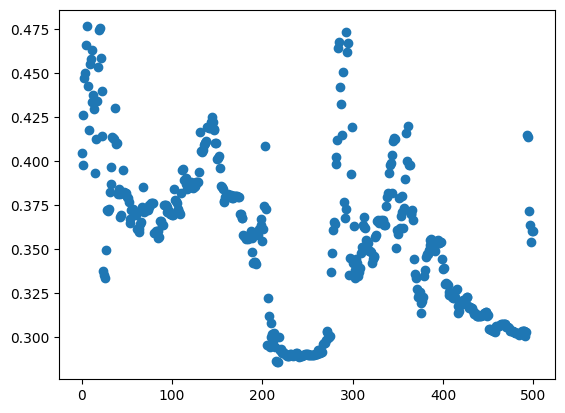

In [5]:
plt.scatter(time, agent1_pref_error)
plt.show()

0.11202624909068673


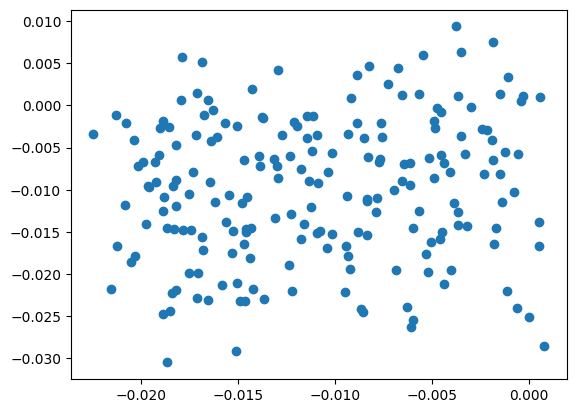

In [6]:
print(np.corrcoef(d_behav1[147], agent2_raw_error_shifted[147])[0][1])
plt.scatter(d_behav1[147], agent2_raw_error_shifted[147])
plt.show()

## Investigation

In [18]:
behav_size = 1
sigmoid_k = 200000000000
sigmoid_b = 20
# behavioral matrix (maps previous behavior to future behavior commands - how should I behave?)
# behavioral matrix (maps previous behavior to future behavior commands - how should I behave?)
B1 = np.random.rand(behav_size, behav_size)
B2 = np.random.rand(behav_size, behav_size)
# B1 = np.array([[1]])
# B2 = np.array([[1]])

# state/system matrix (maps previous state to future state - how will others behave (give past behaviors)?)
A1 = np.random.rand(1, behav_size)
A2 = np.random.rand(1, behav_size)

# reference matrix (how do I expect/want others to behave? target values)
R1 = np.random.rand(1, behav_size)
R2 = np.random.rand(1, behav_size)

# Initial behavior
behav_1 = np.random.rand(1, behav_size)
behav_2 = np.random.rand(1, behav_size)

# transition matrix (maps control signal and previous state to current state - what behaviors do I enact given my intentions?)
T1 = np.array([.05])
T2 = np.array([.05])

color2 = [0.1,0.6,0.2, 0.7]
color2c = [0.2,0.9,0.3, 0.4]

# get the state observation (behaviors of others)
def sense(inputs):
    perception = inputs
    return perception

# contrast reference with observations (and potentially incorporate predictions from internal model)
def compare(sensory_signal, reference, prediction):
    error = reference - sensory_signal
    return error

# generate a control signal
def control(error, behavioral_model, previous_output):
    control_signal = chaotic_controller(behavioral_model, 0.00001, error)
    # print(error, control_signal)
    # print(error/control_signal)
    return control_signal

# dictates how control commands determine state transitions - i.e. behaviors
def transition(control_signal, transition_matrix, state):
    new_state = (transition_matrix * control_signal) + state
    new_state[new_state > 1] = 1
    new_state[new_state < 0] = 0.0001
    return new_state


# adjusts behavioral model to get closer to behavior given 
def control_update(error, behavioral_model, previous_output):
    # LMS algorithm
    learning_rate = 0.0
    #behavioral_model = behavioral_model + learning_rate * error * previous_output
    return behavioral_model

# adjusts reference given error
def reference_update_true(reference, error):
    k = 0.1
    reference = reference - (error * k)
    reference[reference > 1] = 1
    reference[reference < 0] = 0.0001
    return reference

# does not adjust reference
def reference_update_false(reference, error):
    k = 0
    reference = reference + (error * k)
    return reference

def reference_update_sigmoid(reference, error):
    # reference = (matrix_sigmoid(error)-1)*(R1) + matrix_sigmoid(error)*(reference + error)
    sqr_error = np.square(error)
    reference = shifted_sigmoid(sqr_error, sigmoid_k, sigmoid_b)*(reference - error) + (1-shifted_sigmoid(sqr_error, sigmoid_k, sigmoid_b))*(R1)
    # k = 0.1
    # k =  zero_sigmoid(error)
    # reference = reference - (error * k)
    return reference

# generate predictions on next state
def imc(system_estimate, previous_state, behavioral_model, previous_output):
    # actual estimate
    state = (system_estimate * previous_state) + (behavioral_model * previous_output)
    return state

# adjust system estimate to infer observations given my behavior
def imc_update(inputs, system_estimate, previous_behavior, behavioral_model, previous_state, learning_rate):
    # actual estimate
    #curr_system_est = (system_estimate @ previous_state) + (behavioral_model @ previous_behavior)
    #error = curr_system_est - inputs
    #learning_rate = 0.01
    #system_estimate = system_estimate + learning_rate * error * previous_behavior
    return system_estimate

plant1 = Plant(transition_matrix=T1, transition_function=transition, state=behav_1)
plant2 = Plant(transition_matrix=T2, transition_function=transition, state=behav_2)

conformist1 = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_true,
controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
system_estimate=A1, reference=R1, init_behavior=behav_1)

conformist2 = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_true,
controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
system_estimate=A1, reference=R1, init_behavior=behav_1)

stubborn = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_false,
controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B2, 
system_estimate=A2, reference=R2, init_behavior=behav_2)

sigmoid = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_sigmoid,
controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
system_estimate=A1, reference=R1, init_behavior=behav_1)

Seed was: 511


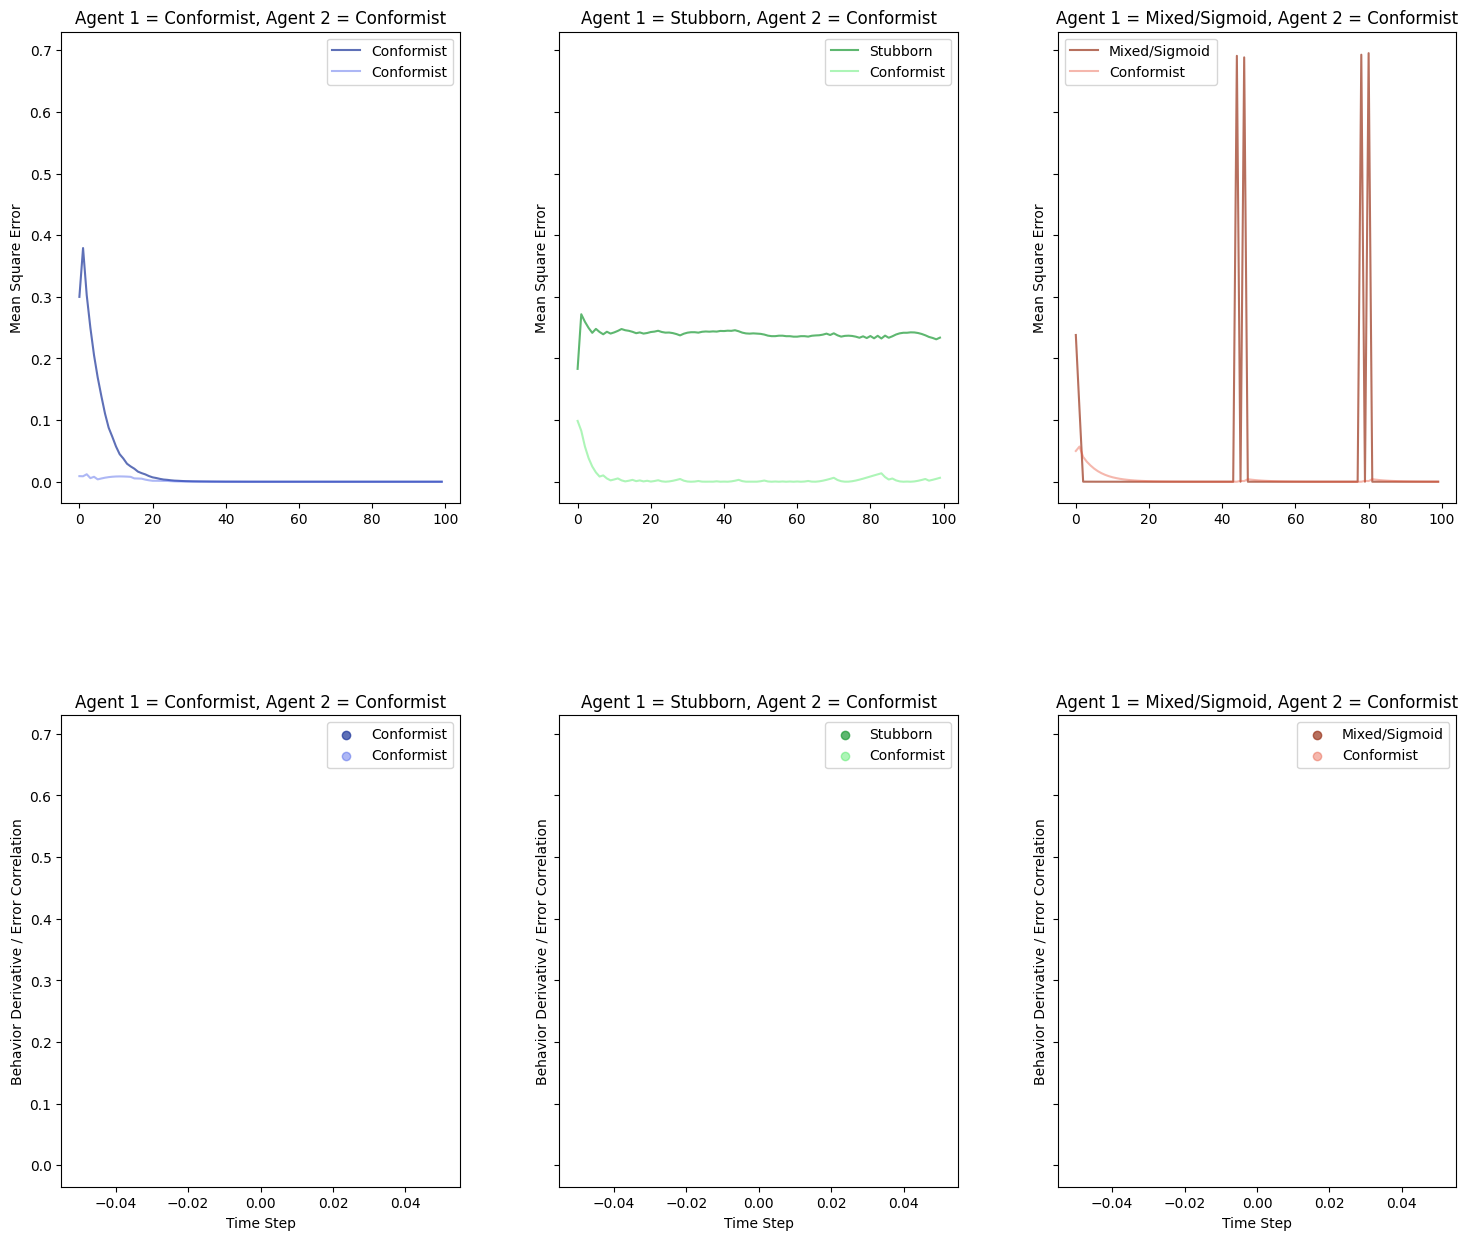

In [118]:
# seed = random.randrange(1000)
seed = 511
# rng = random.Random(seed)
print("Seed was:", seed)
np.random.seed(seed)
w = 6; h = 5
ncols = 3
nrows = 1
param_vals = [i for i in range(0, ncols*nrows)]
tups = list(it.product(range(nrows), range(ncols)))
agents_label = ["Conformist", "Stubborn", "Mixed/Sigmoid"]
agents1 = [conformist2, stubborn, sigmoid]
agents2 = [conformist1, conformist1, conformist1]
fig, ax = plt.subplots(nrows*2, ncols, figsize=(w*ncols, h*nrows*3), dpi=100,
                       sharey=True)#, sharex=True)
plt.subplots_adjust(wspace=0.25,hspace=0.45)
trials = 100
time = [i for i in range(trials)]

color1 = [0.1,0.2,0.6, 0.7]
color1c = [0.2,0.3,0.9, 0.4]
color2 = [0.1,0.6,0.2, 0.7]
color2c = [0.2,0.9,0.3, 0.4]
color3 = [0.6,0.2,0.1, 0.7]
color3c = [0.9,0.3,0.2, 0.4]
colors = [color1,color2,color3]
colors_c = [color1c,color2c,color3c]
color_black = [0.1,0.1,0.1,0.5]

for ix, param in enumerate(param_vals):
    # experiments
    conformist1 = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_true,
    controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
    system_estimate=A1, reference=R1, init_behavior=behav_1)

    conformist2 = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_true,
    controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
    system_estimate=A1, reference=R1, init_behavior=behav_1)

    stubborn = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_false,
    controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B2, 
    system_estimate=A2, reference=R2, init_behavior=behav_2)

    sigmoid = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_sigmoid,
    controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
    system_estimate=A1, reference=R1, init_behavior=behav_1)

    plant1 = Plant(transition_matrix=T1, transition_function=transition, state=np.random.rand(1, behav_size))
    plant2 = Plant(transition_matrix=T2, transition_function=transition, state=np.random.rand(1, behav_size))

    b1 = np.random.rand(1, behav_size)
    b2 = np.random.rand(1, behav_size)

    agent1 = agents1[param%3]
    agent2 = agents2[0]
    agent1_error = []
    agent2_error = []
    agent1_raw_error = []
    agent2_raw_error = []
    sigmoid_value = []
    agent1_behaviors = []
    agent2_behaviors = []
    agent1_control = []
    agent2_control = []
    agent1_reference = []
    agent2_reference = []
    agent1_pref_error = []
    agent2_pref_error = []
    for t in range(trials):
        color1 = [0.1,0.2,0.8, (t+1)/(trials+1)]
        color2 = [0.1,0.8,0.2, (t+1)/(trials+1)]
        #pl.scatter(agent1.get_reference()[0],-0.03, c=color1, edgecolors=[0.8,0.1,0.1, color1[1]])
        #pl.scatter(agent2.get_reference()[0],0, c=color2, edgecolors=[0.8,0.1,0.1, color2[3]], linewidth=1.5)
        b1_control = agent1.go(b2)   
        b2_control = agent2.go(b1)

        agent1_control.append(agent1.get_output())
        agent2_control.append(agent2.get_output())

        b1 = plant1.transition(b1_control)
        b2 = plant2.transition(b2_control)
        
        agent1_behaviors.append(b1)
        agent2_behaviors.append(b2)

        # agent1_error.append(np.absolute(agent1.get_error()))
        # agent2_error.append(np.absolute(agent2.get_error()))
        agent1_raw_error.append(agent1.get_error()[0])
        agent2_raw_error.append(agent2.get_error()[0])
        agent1_pref_error.append(np.sum(np.absolute(R2-b1))/len(agent1.get_error()[0]))
        agent2_pref_error.append(np.sum(np.absolute(R1-b2))/len(agent2.get_error()[0]))
        # if b1[0][0] == 0.0 or b1[0][0] == 1.0:
        #   agent1_raw_error.append(b1[0][0]+0.001)
        # else:
        #   agent1_raw_error.append(agent1.get_error()[0][0])
        # if b2[0][0] == 0.0 or b2[0][0] == 1.0:
        #    agent2_raw_error.append(b2[0][0]+0.001)
        # else:
        #   agent2_raw_error.append(agent2.get_error()[0][0])
        
        agent1_error.append(np.sum(np.square(agent1.get_error()[0]))/len(agent1.get_error()[0]))
        agent2_error.append(np.sum(np.square(agent2.get_error()[0]))/len(agent2.get_error()[0]))
        if agents_label[param] == "Mixed/Sigmoid": 
          sqr_error = np.square(agent2.get_error()[0])
          sigmoid_value.append(shifted_sigmoid(sqr_error, sigmoid_k, sigmoid_b))

        agent1_reference.append(agent1.get_reference()[0])
        agent2_reference.append(agent2.get_reference()[0])

    ai = tups[ix]
    color = colors[param]
    color_c = colors_c[param]
    # plots
    ax[ai].plot(time, agent1_error, color=color, label=agents_label[param])
    ax[ai].plot(time, agent2_error, color=color_c, label="Conformist")
    # if agents_label[param] == "Mixed/Sigmoid": 
    #   ax[ai].plot(time, sigmoid_value, color=color_black, label="Sigmoid Strategy")
    #   print(sigmoid_value)
    ax[ai].set_title('Agent 1 = {}, Agent 2 = Conformist'.format(agents_label[param%3]))
    ax[ai].legend()
    # ax[ai].set_xlim(0,t)
    # ax[ai].set_ylim(0,1)
    ax[ai].tick_params(axis='x')
    ax[ai].tick_params(axis='y')
    ax[ai].set_ylabel("Mean Square Error")
    # ax[ai].set_xlabel("Time Step")

    # derivative charts
    dx = 1
    # b1_flat = [i[0] for i in agent1_control]
    # b2_flat = [i[0] for i in agent2_control]
    b1_flat = [i[0]for i in agent1_behaviors]
    # print("ag 1 behaviors: ", agent1_behaviors)
    # print("ag 1 flat behaviors: ", b1_flat)
    b2_flat = [i[0]for i in agent2_behaviors]
    # d_behav1 = abs(np.gradient(b1_flat, dx))
    # d_behav2 = abs(np.gradient(b2_flat, dx))
    # d_behav1 = np.insert(np.diff(b1_flat, dx), 0, 0)
    d_behav1 = matrix_deriv(np.array(b1_flat), behav_size, trials)[:-1]
    # print("ag 1 behav deriv: ", d_behav1)
    # d_behav2 = np.insert(np.diff(b2_flat, dx), 0, 0)
    d_behav2 = matrix_deriv(np.array(b2_flat), behav_size, trials)[:-1]
    # print("agent1_raw_error: ", agent1_raw_error)
    # agent1_raw_error.insert(-1, 1)
    # print("agent1_raw_error inserted: ", agent1_raw_error)
    # agent2_raw_error.insert(-1, 1)
    agent1_raw_error_shifted = agent1_raw_error[2:]
    agent2_raw_error_shifted = agent2_raw_error[2:]

    # print(agents_label[param%3], "ratio: ", np.average(abs(d_behav1/agent2_raw_error_shifted)))
    # print(agents_label[0], "ratio: ", np.average(abs(d_behav2/agent1_raw_error_shifted)))
    # print(agents_label[param%3], "+ Conformist covariance:", np.cov(np.absolute(d_behav1), np.absolute(agent2_raw_error_shifted)))
    # print(agents_label[0], "&",agents_label[param%3], "covariance:", np.cov(np.absolute(d_behav2), np.absolute(agent1_raw_error_shifted)))
    # print(agents_label[param%3], "& Conformist Pearson R:", np.corrcoef(np.absolute(d_behav1), np.absolute(agent2_raw_error_shifted))[0][1])
    # print(agents_label[0], "&", agents_label[param%3], " Pearson R:", np.corrcoef(np.absolute(d_behav2), np.absolute(agent1_raw_error_shifted))[0][1])
    # print("---")

    # print(agents_label[param])
    # print("error: ", agent2_raw_error_shifted)
    # print("d_behav: ", d_behav1)
    coef1 = [np.corrcoef(d_behav1[i], agent2_raw_error_shifted[i])[0][1] for i in range(len(d_behav1))]
    # print(coef1)
    coef2 = [np.corrcoef(d_behav2[i], agent1_raw_error_shifted[i])[0][1] for i in range(len(d_behav2))]
    
    ax[(ai[0]+1,ai[1])].scatter([ i for i in range(trials-2)], coef1, color=color, label="{}".format(agents_label[param]))
    # ax[(ai[0]+1,ai[1])].scatter(np.absolute(d_behav1), np.absolute(agent2_raw_error_shifted), color=color, label="{}".format(agents_label[param]))
    ax[(ai[0]+1,ai[1])].scatter([ i for i in range(trials-2)], coef2, color=color_c, label="Conformist")
    # ax[(ai[0]+1,ai[1])].scatter(np.absolute(d_behav2), np.absolute(agent1_raw_error_shifted), color=color_c, label="Conformist")

    ax[(ai[0]+1,ai[1])].set_title('Agent 1 = {}, Agent 2 = Conformist'.format(agents_label[param%3]))
    ax[(ai[0]+1,ai[1])].legend()
    # ax[ai].set_ylim(0,1)
    # ax[ai].set_xlim(0,t)
    # ax[(ai[0]+1,ai[1])].set_ylim(0,5)
    ax[(ai[0]+1,ai[1])].tick_params(axis='x')
    ax[(ai[0]+1,ai[1])].tick_params(axis='y')
    ax[(ai[0]+1,ai[1])].set_ylabel("Behavior Derivative / Error Correlation")
    ax[(ai[0]+1,ai[1])].set_xlabel("Time Step")

plt.show()

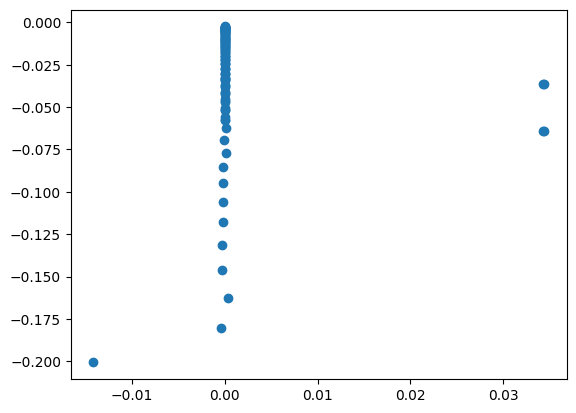

In [119]:
# print(np.corrcoef(d_behav1.flatten(), np.array(agent2_raw_error_shifted).flatten())[0][1])
plt.scatter(d_behav1.flatten(), np.array(agent2_raw_error_shifted).flatten())
plt.show()

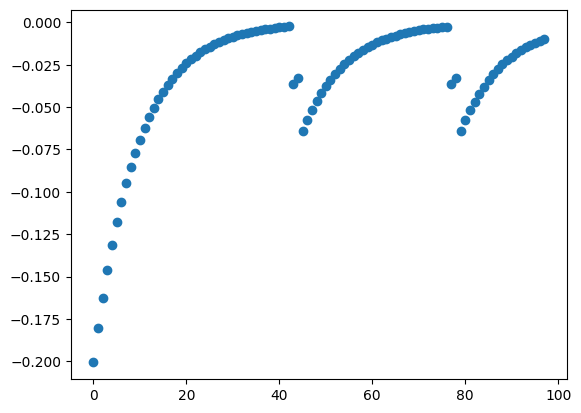

In [120]:
plt.scatter(time[:-2], np.array(agent2_raw_error_shifted).flatten())
plt.show()

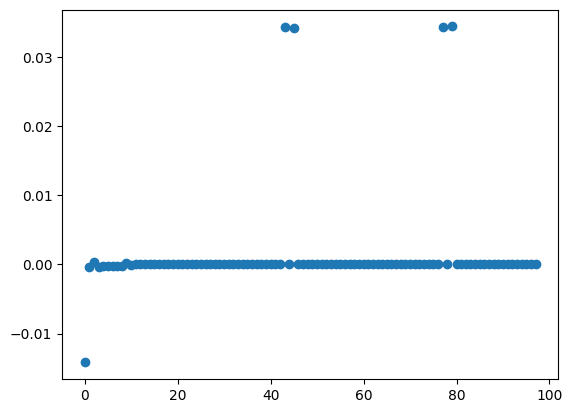

In [121]:
plt.scatter(time[:-2], d_behav1.flatten())
plt.show()

the derivative jump at pos 43 corresponds to the new behavior at pos 44. This is subtracted from the reference at pos 44 to get the raw error at 45. The shifted error makes it 43 to align with the derivative position.

In [123]:
d_behav1.flatten()[40:50]

array([0.        , 0.        , 0.        , 0.03433797, 0.        ,
       0.03427572, 0.        , 0.        , 0.        , 0.        ])

In [124]:
np.array(agent2_raw_error_shifted).flatten()[40:50]

array([-0.0029358 , -0.00264222, -0.002378  , -0.03647817, -0.03283035,
       -0.06382304, -0.05744073, -0.05169666, -0.04652699, -0.0418743 ])

In [125]:
np.array(agent1_behaviors[40:50]).flatten()

array([0.4727584 , 0.4727584 , 0.4727584 , 0.4727584 , 0.50709637,
       0.50709637, 0.54137209, 0.54137209, 0.54137209, 0.54137209])

In [126]:
np.array(agent2_raw_error[40:50]).flatten()

array([-0.00362444, -0.003262  , -0.0029358 , -0.00264222, -0.002378  ,
       -0.03647817, -0.03283035, -0.06382304, -0.05744073, -0.05169666])

In [127]:
np.array(agent2_reference[40:50]).flatten()

array([0.4694964 , 0.4698226 , 0.47011618, 0.4703804 , 0.4706182 ,
       0.47426602, 0.47754905, 0.48393136, 0.48967543, 0.4948451 ])

In [128]:
np.array(agent2_reference[40:50]).flatten() - np.array(agent1_behaviors[30:40]).flatten()

array([-0.003262  , -0.0029358 , -0.00264222, -0.002378  , -0.0021402 ,
        0.00150762,  0.00479065,  0.01117296,  0.01691703,  0.0220867 ])

In [129]:
print(agent2_reference[42][0] - agent1_behaviors[42][0])
print(agent2_raw_error[43])
print(agent2_raw_error_shifted[41])


[-0.00264222]
[-0.00264222]
[-0.00264222]


In [48]:
print(np.array(agent2_reference).flatten())
print(np.array(agent1_behaviors).flatten())
print(np.array(agent2_raw_error).flatten())
print(np.array(agent2_raw_error_shifted).flatten())
print()
print(d_behav1.flatten())

[0.24947273 0.27335565 0.29343159 0.31145917 0.32771826 0.34232068
 0.35543511 0.36721318 0.37779107 0.38729107 0.39582302 0.40351799
 0.4104289  0.41666185 0.4222715  0.42732019 0.43186401 0.43595345
 0.43963395 0.44294639 0.44592759 0.44861067 0.45102545 0.45319874
 0.45515471 0.45691508 0.45849941 0.45992531 0.46120862 0.4623636
 0.46340308 0.46433861 0.46518059 0.46593837 0.46662037 0.46723418
 0.4677866  0.46828378 0.46873124 0.46913396 0.4694964  0.4698226
 0.47011618 0.4703804  0.4706182  0.47426602 0.47754905 0.48393136
 0.48967543 0.4948451  0.4994978  0.50368523 0.50745391 0.51084573
 0.51389837 0.51664574 0.51911838 0.52134375 0.52334658 0.52514913
 0.52677143 0.5282315  0.52954556 0.53072821 0.5317926  0.53275055
 0.5336127  0.53438864 0.53508699 0.5357155  0.53628116 0.53679025
 0.53724843 0.5376608  0.53803193 0.53836595 0.53866656 0.53893711
 0.53918061 0.54283808 0.54612981 0.55253693 0.55830333 0.5634931
 0.56816389 0.5723676  0.57615094 0.57955594 0.58262045 0.5853785